#Traffic Forecasting using Deep Spatio-Temporal Graph 

The dynamics of many real-world phenomena are spatio-temporal in nature. Traffic forecasting is an example of spatio-temporal problems for which we present here a deep learning framework that models speed prediction using spatio-temporal data. Accurate and real-time traffic forecasting plays an important role in the Intelligent Traffic System and is of great significance for traffic planning, traffic management, and traffic control. However, traffic forecasting has always been considered an open scientific issue, owing to the constraints of  road network topological structure and the law of dynamic change with time, namely, spatial dependence and temporal dependence. To capture the spatial and temporal dependence simultaneously, we propose a novel neural network-based traffic forecasting method, the deep spatio-temporal graph convolutional network (DSTGCN) model.
Specifically, the GCN is used to learn complex topological structures to capture spatial dependence and the gated recurrent unit is used to learn dynamic changes of traffic data to capture temporal dependence. Then, the DSTGCN model is employed to traffic forecasting based on the road network. 

The task is challenging due to two main inter-linked factors: (1) the complex spatial dependency on road networks, and (2) non-linear temporal dynamics with changing road conditions.

To address these challenges, a neural network architecture that learns from both the spatial road network data and time-series of historical speed changes to forecast speeds on road segments at a future time. 
In the following we demo how to forecast speeds on road segments through a graph convolution and LSTM hybrid model. The spatial dependency of the road networks are learnt through multiple graph convolution layers stacked over multiple LSTM, sequence to sequence model, layers that leverage the historical speeds on top of the network structure to predict speeds in the future for each entity.

The StellarGraph library supports loading graph information from Pandas. Pandas is a library for working with data frames.The StellarGraph library supports many deep machine learning (ML) algorithms on graphs. Any task using the StellarGraph library needs data to be loaded into an instance of the StellarGraph class. This class stores the graph structure as well as information about them.

In [1]:
# install StellarGraph 
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 5.4 MB/s 
     |████████████████████████████████| 482 kB 43.2 MB/s 
     |████████████████████████████████| 462 kB 27.5 MB/s 
     |████████████████████████████████| 41 kB 518 kB/s 


In [2]:
# checking version of StellarGraph 
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed."
    ) from None

In [32]:
# import libraries
import os
import sys
import urllib.request

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

#Data
We applied the DPTGCN model to the Los-loop data. This traffic dataset contains traffic information collected from loop detectors in the highway of Los Angeles County. We have used the preprocessed version of the dataset used by the TGCN paper.This dataset contains traffic speeds from Mar.1 to Mar.7, 2012 of 207 sensors, recorded every 5 minutes.

## Loading and Preprocessing of the data

In [4]:
import stellargraph as sg

This demo is based on the preprocessed version of the dataset used by the TGCN paper.

In [ ]:
dataset = sg.datasets.METR_LA()

In [6]:
speed_data, sensor_dist_adj = dataset.load()
num_nodes, time_len = speed_data.shape
print("No. of sensors:", num_nodes, "\nNo of timesteps:", time_len)

No. of sensors: 207 
No of timesteps: 2016


sample of speed data

In [7]:
speed_data.head()

,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
773869,64.375,62.666667,64.00,61.777778,59.555556,57.333333,66.500,63.625,68.750,63.500,...,64.625,65.444444,63.125,62.875,68.375,65.555556,66.625,66.375,64.666667,66.000
767541,67.625,68.555556,63.75,65.500000,67.250000,69.000000,63.875,67.250,65.250,61.500,...,67.125,66.555556,68.125,67.125,67.000,65.111111,66.625,66.375,66.555556,67.125
767542,67.125,65.444444,60.00,62.555556,65.111111,67.666667,67.875,63.250,63.500,62.500,...,66.500,66.222222,67.625,68.625,68.500,64.111111,65.750,63.750,66.888889,66.375
717447,61.500,62.444444,59.00,59.888889,60.777778,61.666667,62.375,60.500,63.000,58.125,...,55.625,61.000000,58.750,60.625,61.375,61.111111,64.750,63.750,59.888889,59.250
717446,66.875,64.444444,66.50,66.777778,67.055556,67.333333,64.375,57.375,65.125,66.625,...,65.625,58.000000,66.625,67.125,64.500,66.000000,67.375,67.625,65.111111,64.250


As you can see above, there are 2016 observations (timesteps) of speed records over 207 sensors. Speeds are recorded every 5 minutes.  



### Train/test Split

Just like for modeling any standard supervised learning problem, we first split the data into mutually exclusive train and test sets. 
In the following we use first 80% observations for training and the rest for testing.

In [8]:
def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:, :train_size])
    test_data = np.array(data.iloc[:, train_size:])
    return train_data, test_data

In [9]:
train_rate = 0.8

In [10]:
train_data, test_data = train_test_split(speed_data, train_rate)
print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)

Train data:  (207, 1612)
Test data:  (207, 404)


### Scaling
Here we are rescaling  the data from the original range so that all values are within the range of 0 and 1. Normalization can be useful and even necessary when time series data has input values with differing scales.  In the following we normalize the speed timeseries by the maximum and minimum values of speeds in the train data. 

Note: `MinMaxScaler` in `scikit learn` library is typically used for transforming data.We use the maximum and the minimum of the entire range of values in the timeseries to scale and transform the train and test sets respectively.

In [11]:
def scale_data(train_data, test_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled

In [12]:
train_scaled, test_scaled = scale_data(train_data, test_data)

### Sequence data preparation for LSTM

We first need to prepare the data to be fed into an LSTM. 
The LSTM model learns a function that maps a sequence of past observations as input to an output observation. As such, the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

In terms of the speed prediction problem, we choose to use 50 minutes of historical speed observations to predict the speed in future, lets say, 1 hour ahead. Hence, we would first  reshape the timeseries data into windows of 10 historical observations for each segment as the input and the speed 60 minutes later is the label we are interested in predicting. We use the sliding window approach to prepare the data. This is how it works:  

* Starting from the beginning of the timeseries, we take the first 10 speed records as the 10 input features and the speed 12 timesteps head (60 minutes) as the speed we want to predict. 
* Shift the timeseries by one timestep and take the 10 observations from the current point as the input features and the speed one hour ahead as the output to predict. 
* Keep shifting by 1 timestep and picking the 10 timestep window from the current time as input feature and the speed one hour ahead of the 10th timestep as the output to predict, for the entire data.
* The above steps are done for each sensor. 

The function below returns the above transformed timeseries data for the model to train on. The parameter `seq_len` is the size of the past window of information. The `pre_len` is how far in the future does the model need to learn to predict. 

For this demo: 

* Each training observation are 10 historical speeds (`seq_len`).
* Each training prediction is the speed 60 minutes later (`pre_len`).

In [13]:
seq_len = 10
pre_len = 12

In [14]:
def sequence_data_preparation(seq_len, pre_len, train_data, test_data):
    trainX, trainY, testX, testY = [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)

    return trainX, trainY, testX, testY

In [15]:
trainX, trainY, testX, testY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled
)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1591, 207, 10)
(1591, 207)
(383, 207, 10)
(383, 207)


## StellarGraph Graph Convolution and LSTM model

In [16]:
from stellargraph.layer import GCN_LSTM

In [ ]:
gcn_lstm = GCN_LSTM(
    seq_len=seq_len,
    adj=sensor_dist_adj,
    gc_layer_sizes=[16, 10],
    gc_activations=["relu", "relu"],
    lstm_layer_sizes=[200, 200],
    lstm_activations=["tanh", "tanh"],
)

In [18]:
x_input, x_output = gcn_lstm.in_out_tensors()

In [19]:
model = Model(inputs=x_input, outputs=x_output)

In [20]:
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

In [21]:
history = model.fit(
    trainX,
    trainY,
    epochs=100,
    batch_size=60,
    shuffle=True,
    verbose=0,
    validation_data=[testX, testY],
)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 207, 10)]         0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 207, 10, 1)       0         
                                                                 
 reshape (Reshape)           (None, 207, 10)           0         
                                                                 
 fixed_adjacency_graph_convo  (None, 207, 16)          43216     
 lution (FixedAdjacencyGraph                                     
 Convolution)                                                    
                                                                 
 fixed_adjacency_graph_convo  (None, 207, 10)          43216     
 lution_1 (FixedAdjacencyGra                                     
 phConvolution)                                              

In [23]:
print(
    "Train loss: ",
    history.history["loss"][-1],
    "\nTest loss:",
    history.history["val_loss"][-1],
)

Train loss:  0.05337412655353546 
Test loss: 0.06270340085029602


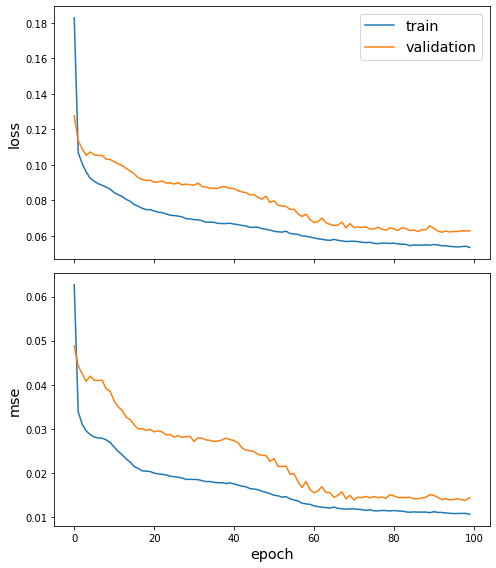

In [24]:
sg.utils.plot_history(history)

In [25]:
ythat = model.predict(trainX)
yhat = model.predict(testX)

## Rescale values

Rescale the predicted values to the original value range of the timeseries.

In [26]:
## Rescale values
max_speed = train_data.max()
min_speed = train_data.min()

## actual train and test values
train_rescref = np.array(trainY * max_speed)
test_rescref = np.array(testY * max_speed)

In [27]:
## Rescale model predicted values
train_rescpred = np.array((yhat) * max_speed)
test_rescpred = np.array((yhat) * max_speed)

## Performance of the model

To understand how well the model is performing, we compare it against a naive benchmark.

Naive prediction: using the most recently **observed** value as the predicted value. When speeds are recorded at a 5 minutes granularity,  one does not expect many drastic changes within such a short period of time. Hence, for short-term predictions naive is a reasonable good guess.

### Naive prediction benchmark 

In [34]:
## Naive prediction benchmark 

testnpred = np.array(testX)[
    :, :, -1
]  # picking the last speed of the 10 sequence for each segment in each sample
testnpredc = (testnpred) * max_speed

In [36]:
## Performance measures

seg_mael = []
seg_masel = []
seg_nmael = []

for j in range(testX.shape[-1]):

    seg_mael.append(
        np.mean(np.abs(test_rescref.T[j] - test_rescpred.T[j]))
    )  # Mean Absolute Error for NN
    seg_nmael.append(
        np.mean(np.abs(test_rescref.T[j] - testnpredc.T[j]))
    )  # Mean Absolute Error for naive prediction
    if seg_nmael[-1] != 0:
        seg_masel.append(
            seg_mael[-1] / seg_nmael[-1]
        )  # Ratio of the two: Mean Absolute Scaled Error
    else:
        seg_masel.append(np.NaN)

print("Total (ave) MAE for NN: " + str(np.mean(np.array(seg_mael))))
print("Total (ave) MAE for naive prediction: " + str(np.mean(np.array(seg_nmael))))
print(
    "Total (ave) MASE for per-segment NN/naive MAE: "
    + str(np.nanmean(np.array(seg_masel)))
)
print(
    "If MASE<1 then NN prediction is better than the naive prediction."
)

Total (ave) MAE for NN: 4.071130432347649
Total (ave) MAE for naive prediction: 5.619645381284217
Total (ave) MASE for per-segment NN/naive MAE: 0.7152859161443188
If MASE<1 then NN prediction is better than the naive prediction.


#### Plot of actual and predicted speeds on a sample sensor

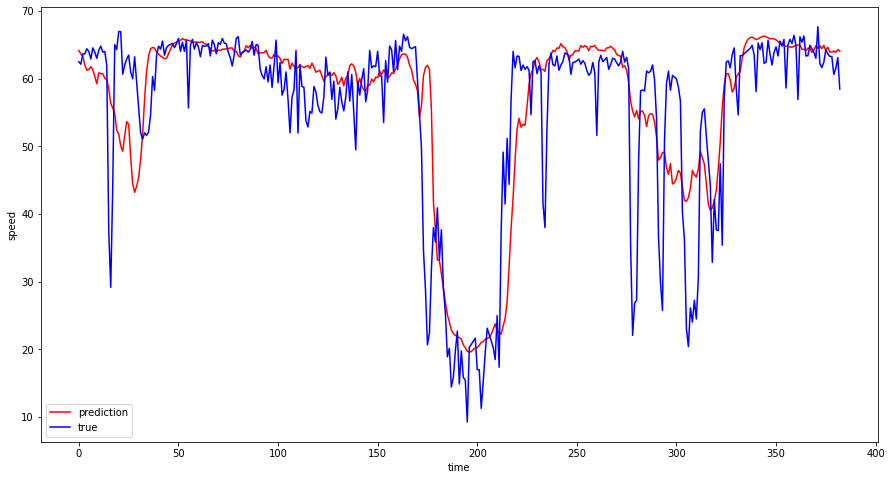

In [31]:
##all test result visualization
fig1 = plt.figure(figsize=(15, 8))
#    ax1 = fig1.add_subplot(1,1,1)
a_pred = test_rescpred[:, 100]
a_true = test_rescref[:, 100]
plt.plot(a_pred, "r-", label="prediction")
plt.plot(a_true, "b-", label="true")
plt.xlabel("time")
plt.ylabel("speed")
plt.legend(loc="best", fontsize=10)
plt.show()

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/time-series/gcn-lstm-time-series.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/time-series/gcn-lstm-time-series.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>